# DBSCAN Product Clustering: Complete Evaluation

## Research Question
**Can DBSCAN successfully cluster similar product titles together?**

For example:
- `"apple iphone 8 plus 64gb silver"` → Cluster A
- `"apple iphone 8 plus 64 gb spacegrau"` → Cluster A
- `"apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim free smartphone in gold"` → Cluster A

## Evaluation Strategy
We have **ground truth cluster labels** from PriceRunner, which allows us to:
1. Measure how well DBSCAN discovers similar products (External Metrics: ARI, NMI, etc.)
2. Assess internal cluster quality (Silhouette, Davies-Bouldin)
3. Analyze how DBSCAN handles different cluster sizes
4. Understand the trade-off between cluster purity and coverage

## Important Design Decision
We **do NOT filter small clusters** before clustering because:
- It creates circular logic (using ground truth to preprocess for unsupervised learning)
- It biases evaluation metrics
- It prevents us from seeing how DBSCAN naturally handles outliers
- DBSCAN is designed to identify noise/outliers as part of its algorithm

Instead, we'll analyze performance separately for:
- Large clusters (common products)
- Small clusters (rare products)
- Overall dataset

---

## 1. Data Loading & Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score
)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load full dataset - NO FILTERING
product = pd.read_csv('pricerunner_aggregate.csv')

print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(f"Total products: {len(product):,}")
print(f"Total ground truth clusters: {product[' Cluster ID'].nunique()}")
print(f"Columns: {list(product.columns)}")

print(f"\n📊 Ground Truth Cluster Distribution:")
cluster_sizes = product[' Cluster ID'].value_counts()
print(f"  Mean cluster size: {cluster_sizes.mean():.2f}")
print(f"  Median cluster size: {cluster_sizes.median():.2f}")
print(f"  Min cluster size: {cluster_sizes.min()}")
print(f"  Max cluster size: {cluster_sizes.max()}")
print(f"  Clusters with 1 product: {(cluster_sizes == 1).sum()}")
print(f"  Clusters with 2-3 products: {((cluster_sizes >= 2) & (cluster_sizes <= 3)).sum()}")
print(f"  Clusters with 4+ products: {(cluster_sizes >= 4).sum()}")

print(f"\n📝 Sample Products:")
print(product[['Product Title', ' Cluster ID', ' Cluster Label']].head(10))
print("=" * 70)

DATASET OVERVIEW
Total products: 35,311
Total ground truth clusters: 13233
Columns: ['Product ID', 'Product Title', ' Merchant ID', ' Cluster ID', ' Cluster Label', ' Category ID', ' Category Label']

📊 Ground Truth Cluster Distribution:
  Mean cluster size: 2.67
  Median cluster size: 2.00
  Min cluster size: 1
  Max cluster size: 27
  Clusters with 1 product: 5374
  Clusters with 2-3 products: 5357
  Clusters with 4+ products: 2502

📝 Sample Products:
                                       Product Title   Cluster ID  \
0                    apple iphone 8 plus 64gb silver            1   
1                apple iphone 8 plus 64 gb spacegrau            1   
2  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...            1   
3                apple iphone 8 plus 64gb space grey            1   
4  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...            1   
5  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...            1   
6               apple iphone 8 plus 64 gb space grey       

## 2. Feature Engineering: TF-IDF Vectorization

Transform product titles into high-dimensional sparse vectors using TF-IDF.

In [3]:
# Create TF-IDF features from product titles
print("Creating TF-IDF features...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=500,  # Limit features for computational efficiency
    min_df=2,          # Ignore rare terms (appear in <2 documents)
    max_df=0.8,        # Ignore common terms (appear in >80% of documents)
    lowercase=True,
    ngram_range=(1, 2) # Include unigrams and bigrams
)

product_features = tfidf_vectorizer.fit_transform(product['Product Title'])

print(f"\n✓ TF-IDF Encoding Complete!")
print(f"  Shape: {product_features.shape}")
print(f"  - {product_features.shape[0]:,} products")
print(f"  - {product_features.shape[1]} features")
print(f"  Sparsity: {(1.0 - product_features.nnz / (product_features.shape[0] * product_features.shape[1])) * 100:.2f}%")
print(f"\n  Sample features: {list(tfidf_vectorizer.get_feature_names_out())[:20]}")

Creating TF-IDF features...

✓ TF-IDF Encoding Complete!
  Shape: (35311, 500)
  - 35,311 products
  - 500 features
  Sparsity: 98.49%

  Sample features: ['10', '1080p', '10kg', '12', '12 place', '1200', '1200 spin', '1200rpm', '128gb', '12mb', '12mb l3', '13', '13 place', '14', '14 place', '1400', '1400 spin', '1400rpm', '1400rpm freestanding', '15']

✓ TF-IDF Encoding Complete!
  Shape: (35311, 500)
  - 35,311 products
  - 500 features
  Sparsity: 98.49%

  Sample features: ['10', '1080p', '10kg', '12', '12 place', '1200', '1200 spin', '1200rpm', '128gb', '12mb', '12mb l3', '13', '13 place', '14', '14 place', '1400', '1400 spin', '1400rpm', '1400rpm freestanding', '15']


## 3. DBSCAN Parameter Tuning

### 3.1 K-Distance Graph for eps Selection

K-DISTANCE ANALYSIS FOR EPS SELECTION
Computing 4-nearest neighbors...
  → Suggested eps for k=4: 0.2760
Computing 5-nearest neighbors...
  → Suggested eps for k=4: 0.2760
Computing 5-nearest neighbors...
  → Suggested eps for k=5: 0.2924
Computing 6-nearest neighbors...
  → Suggested eps for k=5: 0.2924
Computing 6-nearest neighbors...
  → Suggested eps for k=6: 0.3238
Computing 8-nearest neighbors...
  → Suggested eps for k=6: 0.3238
Computing 8-nearest neighbors...
  → Suggested eps for k=8: 0.3412
Computing 10-nearest neighbors...
  → Suggested eps for k=8: 0.3412
Computing 10-nearest neighbors...
  → Suggested eps for k=10: 0.3496
  → Suggested eps for k=10: 0.3496


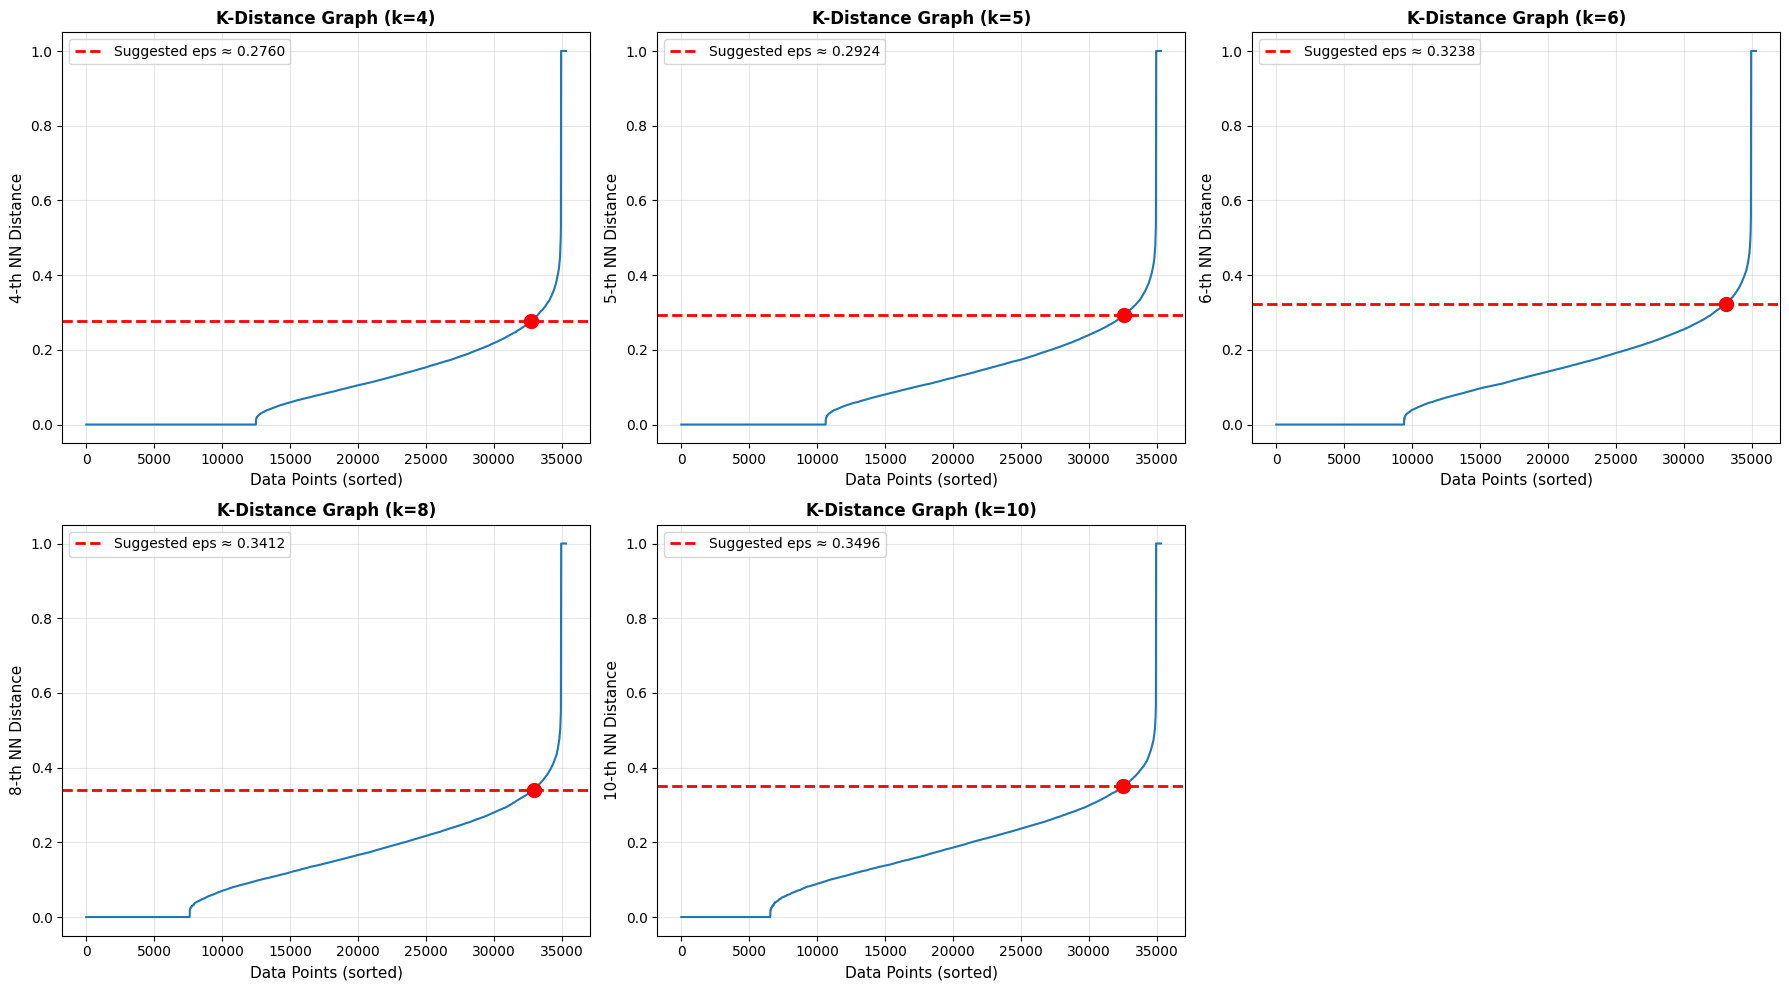


RECOMMENDATIONS:
  min_samples= 4 → eps ≈ 0.2760
  min_samples= 5 → eps ≈ 0.2924
  min_samples= 6 → eps ≈ 0.3238
  min_samples= 8 → eps ≈ 0.3412
  min_samples=10 → eps ≈ 0.3496


In [4]:
def plot_k_distance_graph(X, k_values=[4, 5, 6, 8, 10]):
    """
    Plot k-distance graphs to find optimal eps.
    The elbow point suggests the optimal eps value.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    recommended_eps = {}
    
    for idx, k in enumerate(k_values):
        print(f"Computing {k}-nearest neighbors...")
        
        neighbors = NearestNeighbors(n_neighbors=k, metric='cosine', n_jobs=-1)
        neighbors.fit(X)
        distances, indices = neighbors.kneighbors(X)
        
        k_distances = np.sort(distances[:, -1])
        
        ax = axes[idx]
        ax.plot(k_distances, linewidth=1.5)
        ax.set_xlabel('Data Points (sorted)', fontsize=11)
        ax.set_ylabel(f'{k}-th NN Distance', fontsize=11)
        ax.set_title(f'K-Distance Graph (k={k})', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Find elbow using perpendicular distance method
        first_point = np.array([0, k_distances[0]])
        last_point = np.array([len(k_distances) - 1, k_distances[-1]])
        line_vec = last_point - first_point
        line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
        vec_from_first = np.array([[i, k_distances[i]] for i in range(len(k_distances))]) - first_point
        distances_to_line = np.abs(np.cross(vec_from_first, line_vec_norm.reshape(1, -1)))
        elbow_idx = np.argmax(distances_to_line)
        elbow_distance = k_distances[elbow_idx]
        
        ax.axhline(y=elbow_distance, color='red', linestyle='--', linewidth=2,
                   label=f'Suggested eps ≈ {elbow_distance:.4f}')
        ax.scatter([elbow_idx], [elbow_distance], color='red', s=100, zorder=5)
        ax.legend(fontsize=10)
        
        recommended_eps[k] = elbow_distance
        print(f"  → Suggested eps for k={k}: {elbow_distance:.4f}")
    
    if len(k_values) < len(axes):
        for idx in range(len(k_values), len(axes)):
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return recommended_eps

print("=" * 70)
print("K-DISTANCE ANALYSIS FOR EPS SELECTION")
print("=" * 70)

eps_recommendations = plot_k_distance_graph(product_features, k_values=[4, 5, 6, 8, 10])

print("\n" + "=" * 70)
print("RECOMMENDATIONS:")
for k, eps in eps_recommendations.items():
    print(f"  min_samples={k:2d} → eps ≈ {eps:.4f}")
print("=" * 70)

### 3.2 Grid Search with Comprehensive Evaluation

In [5]:
def evaluate_dbscan(X, labels_pred, labels_true):
    """
    Comprehensive DBSCAN evaluation.
    """
    metrics = {}
    
    # Count clusters and noise
    n_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
    n_noise = list(labels_pred).count(-1)
    n_total = len(labels_pred)
    
    metrics['n_clusters'] = n_clusters
    metrics['n_noise'] = n_noise
    metrics['noise_ratio'] = n_noise / n_total
    
    # Internal metrics (skip if too few clusters or too much noise)
    if n_clusters < 2 or n_noise > n_total * 0.9:
        metrics['silhouette'] = -999
        metrics['davies_bouldin'] = 999
    else:
        mask = labels_pred != -1
        if mask.sum() > 1:
            try:
                metrics['silhouette'] = silhouette_score(X[mask], labels_pred[mask], metric='cosine')
            except:
                metrics['silhouette'] = -999
            
            try:
                X_dense = X[mask].toarray() if hasattr(X[mask], 'toarray') else X[mask]
                metrics['davies_bouldin'] = davies_bouldin_score(X_dense, labels_pred[mask])
            except:
                metrics['davies_bouldin'] = 999
        else:
            metrics['silhouette'] = -999
            metrics['davies_bouldin'] = 999
    
    # External metrics
    try:
        metrics['ari'] = adjusted_rand_score(labels_true, labels_pred)
        metrics['nmi'] = normalized_mutual_info_score(labels_true, labels_pred)
        metrics['homogeneity'] = homogeneity_score(labels_true, labels_pred)
        metrics['completeness'] = completeness_score(labels_true, labels_pred)
        metrics['v_measure'] = v_measure_score(labels_true, labels_pred)
    except:
        metrics['ari'] = -999
        metrics['nmi'] = -999
        metrics['homogeneity'] = -999
        metrics['completeness'] = -999
        metrics['v_measure'] = -999
    
    return metrics

# Define parameter grid
eps_values = sorted(set(eps_recommendations.values()))
eps_min = min(eps_values) * 0.8
eps_max = max(eps_values) * 1.2
eps_grid = np.linspace(eps_min, eps_max, 15)
min_samples_grid = [4, 5, 6, 8, 10, 12]

print("=" * 70)
print("GRID SEARCH CONFIGURATION")
print("=" * 70)
print(f"eps values: {len(eps_grid)} (range: [{eps_min:.4f}, {eps_max:.4f}])")
print(f"min_samples values: {len(min_samples_grid)} {min_samples_grid}")
print(f"Total combinations: {len(eps_grid) * len(min_samples_grid)}")
print("=" * 70)

# Ground truth labels
labels_true = product[' Cluster ID'].values

# Grid search
results = []
print("\nRunning grid search...")

for eps in tqdm(eps_grid, desc="eps values"):
    for min_samples in min_samples_grid:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
        labels_pred = dbscan.fit_predict(product_features)
        
        metrics = evaluate_dbscan(product_features, labels_pred, labels_true)
        
        result = {'eps': eps, 'min_samples': min_samples, **metrics}
        results.append(result)

results_df = pd.DataFrame(results)
print(f"\n✓ Grid search complete! Evaluated {len(results)} combinations.")

GRID SEARCH CONFIGURATION
eps values: 15 (range: [0.2208, 0.4195])
min_samples values: 6 [4, 5, 6, 8, 10, 12]
Total combinations: 90

Running grid search...


eps values: 100%|██████████| 15/15 [29:56<00:00, 119.74s/it]


✓ Grid search complete! Evaluated 90 combinations.


### 3.3 Select Best Parameters

In [9]:
# Filter valid results
results_valid = results_df[
    (results_df['n_clusters'] >= 2) & 
    (results_df['noise_ratio'] < 0.5) &
    (results_df['silhouette'] > -900)
].copy()

print("=" * 70)
print("RESULTS FILTERING")
print("=" * 70)
print(f"Total combinations: {len(results_df)}")
print(f"Valid combinations: {len(results_valid)}")

if len(results_valid) > 0:
    # Normalize metrics for composite score
    results_valid['ari_norm'] = (results_valid['ari'] - results_valid['ari'].min()) / (results_valid['ari'].max() - results_valid['ari'].min() + 1e-10)
    results_valid['silhouette_norm'] = (results_valid['silhouette'] - results_valid['silhouette'].min()) / (results_valid['silhouette'].max() - results_valid['silhouette'].min() + 1e-10)
    results_valid['noise_norm'] = 1 - results_valid['noise_ratio']
    
    # Composite score (weighted)
    results_valid['composite_score'] = (
        0.40 * results_valid['ari_norm'] +
        0.30 * results_valid['silhouette_norm'] +
        0.30 * results_valid['noise_norm']
    )
    
    # Get best parameters
    best = results_valid.loc[results_valid['composite_score'].idxmax()]
    
    print("\n" + "=" * 70)
    print("🎯 BEST PARAMETERS")
    print("=" * 70)
    print(f"  eps: {best['eps']:.4f}")
    print(f"  min_samples: {int(best['min_samples'])}")
    print(f"\n  Performance:")
    print(f"    ARI: {best['ari']:.4f}")
    print(f"    NMI: {best['nmi']:.4f}")
    print(f"    Silhouette: {best['silhouette']:.4f}")
    print(f"    Clusters: {int(best['n_clusters'])}")
    print(f"    Noise Ratio: {best['noise_ratio']:.2%}")
    print("=" * 70)
    
    # Show top 10
    print("\n📊 Top 10 Parameter Combinations:")
    print(results_valid.nlargest(10, 'composite_score')[[
        'eps', 'min_samples', 'ari', 'nmi', 'silhouette', 'n_clusters', 'noise_ratio', 'composite_score'
    ]].to_string(index=False))
else:
    print("\n⚠️ No valid results found. Consider adjusting parameter ranges.")

RESULTS FILTERING
Total combinations: 90
Valid combinations: 90

🎯 BEST PARAMETERS
  eps: 0.2208
  min_samples: 12

  Performance:
    ARI: 0.0009
    NMI: 0.4448
    Silhouette: 0.0751
    Clusters: 183
    Noise Ratio: 21.42%

📊 Top 10 Parameter Combinations:
     eps  min_samples      ari      nmi  silhouette  n_clusters  noise_ratio  composite_score
0.220762           12 0.000939 0.444760    0.075123         183     0.214239         0.929676
0.220762           10 0.000953 0.426698    0.005131         180     0.189856         0.880810
0.234957           12 0.000811 0.391077   -0.013665         126     0.179236         0.807543
0.220762            8 0.000737 0.390645   -0.076580         189     0.161083         0.725845
0.234957           10 0.000697 0.366637   -0.069511         122     0.157231         0.716106
0.234957            8 0.000646 0.356014   -0.120523         127     0.132338         0.656863
0.220762            6 0.000666 0.379606   -0.136062         210     0.130328    

## 4. Apply Best Parameters & Comprehensive Analysis

In [10]:
if len(results_valid) > 0:
    # Run final DBSCAN
    best_eps = best['eps']
    best_min_samples = int(best['min_samples'])
    
    print(f"Running final DBSCAN with eps={best_eps:.4f}, min_samples={best_min_samples}...")
    
    final_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='cosine', n_jobs=-1)
    final_labels = final_dbscan.fit_predict(product_features)
    
    # Add to dataframe
    product['DBSCAN_Cluster'] = final_labels
    
    # Analysis
    n_clusters_found = len(set(final_labels)) - (1 if -1 in final_labels else 0)
    n_noise = list(final_labels).count(-1)
    
    print("\n" + "=" * 70)
    print("FINAL CLUSTERING RESULTS")
    print("=" * 70)
    print(f"Ground Truth Clusters: {product[' Cluster ID'].nunique()}")
    print(f"DBSCAN Clusters: {n_clusters_found}")
    print(f"Noise Points: {n_noise} ({n_noise/len(final_labels)*100:.1f}%)")
    print(f"Clustered Points: {len(final_labels) - n_noise} ({(1-n_noise/len(final_labels))*100:.1f}%)")
    print("=" * 70)
    
    # Save results
    results_df.to_csv('dbscan_grid_search_results.csv', index=False)
    product.to_csv('pricerunner_dbscan_final_results.csv', index=False)
    print("\n✓ Saved: dbscan_grid_search_results.csv")
    print("✓ Saved: pricerunner_dbscan_final_results.csv")

Running final DBSCAN with eps=0.2208, min_samples=12...

FINAL CLUSTERING RESULTS
Ground Truth Clusters: 13233
DBSCAN Clusters: 183
Noise Points: 7565 (21.4%)
Clustered Points: 27746 (78.6%)

✓ Saved: dbscan_grid_search_results.csv
✓ Saved: pricerunner_dbscan_final_results.csv

FINAL CLUSTERING RESULTS
Ground Truth Clusters: 13233
DBSCAN Clusters: 183
Noise Points: 7565 (21.4%)
Clustered Points: 27746 (78.6%)

✓ Saved: dbscan_grid_search_results.csv
✓ Saved: pricerunner_dbscan_final_results.csv


## 5. Stratified Analysis: Large vs Small Ground Truth Clusters

Analyze DBSCAN performance separately for common vs rare products.

In [12]:
if len(results_valid) > 0:
    # Categorize ground truth clusters by size
    gt_cluster_sizes = product.groupby(' Cluster ID').size()
    
    large_clusters = gt_cluster_sizes[gt_cluster_sizes >= 10].index
    medium_clusters = gt_cluster_sizes[(gt_cluster_sizes >= 4) & (gt_cluster_sizes < 10)].index
    small_clusters = gt_cluster_sizes[gt_cluster_sizes < 4].index
    
    print("=" * 70)
    print("STRATIFIED ANALYSIS: Performance by GT Cluster Size")
    print("=" * 70)
    
    for cluster_ids, name, description in [
        (large_clusters, 'Large', '≥10 products'),
        (medium_clusters, 'Medium', '4-9 products'),
        (small_clusters, 'Small', '1-3 products')
    ]:
        mask = product[' Cluster ID'].isin(cluster_ids)
        subset = product[mask]
        
        if len(subset) > 0:
            subset_labels_true = subset[' Cluster ID'].values
            subset_labels_pred = subset['DBSCAN_Cluster'].values
            
            noise_ratio = (subset_labels_pred == -1).mean()
            ari = adjusted_rand_score(subset_labels_true, subset_labels_pred)
            nmi = normalized_mutual_info_score(subset_labels_true, subset_labels_pred)
            
            print(f"\n{name} Clusters ({description}):")
            print(f"  Products: {len(subset):,} ({len(subset)/len(product)*100:.1f}% of total)")
            print(f"  GT Clusters: {len(cluster_ids)}")
            print(f"  ARI: {ari:.4f}")
            print(f"  NMI: {nmi:.4f}")
            print(f"  Noise Ratio: {noise_ratio:.2%}")
    
    print("\n" + "=" * 70)
    print("KEY INSIGHTS:")
    print("  • Large clusters: DBSCAN should perform best here")
    print("  • Medium clusters: Moderate performance expected")
    print("  • Small clusters: Higher noise ratio is natural/expected")
    print("=" * 70)

STRATIFIED ANALYSIS: Performance by GT Cluster Size

Large Clusters (≥10 products):
  Products: 4,652 (13.2% of total)
  GT Clusters: 368
  ARI: 0.0224
  NMI: 0.4686
  Noise Ratio: 17.58%

Medium Clusters (4-9 products):
  Products: 12,005 (34.0% of total)
  GT Clusters: 2134
  ARI: 0.0028
  NMI: 0.4489
  Noise Ratio: 20.65%

Small Clusters (1-3 products):
  Products: 18,654 (52.8% of total)
  GT Clusters: 10731
  ARI: 0.0005
  NMI: 0.4728
  Noise Ratio: 22.88%

KEY INSIGHTS:
  • Large clusters: DBSCAN should perform best here
  • Medium clusters: Moderate performance expected
  • Small clusters: Higher noise ratio is natural/expected


## 6. Cluster Purity Analysis

Measure how "pure" each DBSCAN cluster is (what % comes from a single GT cluster).

CLUSTER PURITY ANALYSIS
Average Purity: 0.084
Median Purity: 0.062

Purity Breakdown:
  Perfect (1.0): 0 clusters (0.0%)
  High (≥0.9): 0 clusters (0.0%)
  Good (≥0.75): 0 clusters (0.0%)

Merging:
  Pure (1 GT): 0 clusters
  Merged (≥2 GT): 183 clusters


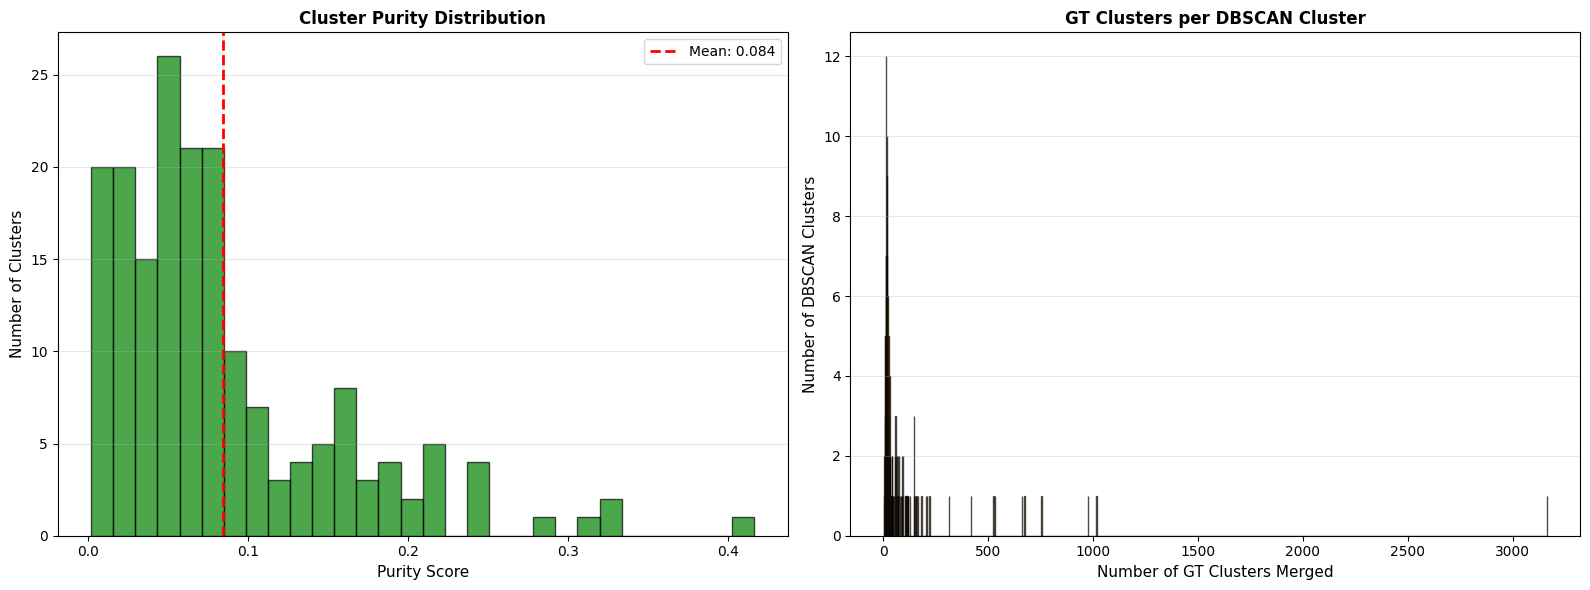


✓ Saved: cluster_purity_analysis.csv


In [13]:
if len(results_valid) > 0:
    # Calculate purity for each DBSCAN cluster
    df_clustered = product[product['DBSCAN_Cluster'] != -1].copy()
    
    purity_results = []
    for cluster_id in sorted(df_clustered['DBSCAN_Cluster'].unique()):
        cluster_data = df_clustered[df_clustered['DBSCAN_Cluster'] == cluster_id]
        gt_distribution = cluster_data[' Cluster ID'].value_counts()
        
        purity = gt_distribution.iloc[0] / len(cluster_data) if len(cluster_data) > 0 else 0
        
        purity_results.append({
            'DBSCAN_Cluster': cluster_id,
            'Purity': purity,
            'Dominant_GT': gt_distribution.index[0],
            'Size': len(cluster_data),
            'Num_GT_Merged': cluster_data[' Cluster ID'].nunique()
        })
    
    purity_df = pd.DataFrame(purity_results)
    
    print("=" * 70)
    print("CLUSTER PURITY ANALYSIS")
    print("=" * 70)
    print(f"Average Purity: {purity_df['Purity'].mean():.3f}")
    print(f"Median Purity: {purity_df['Purity'].median():.3f}")
    print(f"\nPurity Breakdown:")
    print(f"  Perfect (1.0): {(purity_df['Purity'] == 1.0).sum()} clusters ({(purity_df['Purity'] == 1.0).mean()*100:.1f}%)")
    print(f"  High (≥0.9): {(purity_df['Purity'] >= 0.9).sum()} clusters ({(purity_df['Purity'] >= 0.9).mean()*100:.1f}%)")
    print(f"  Good (≥0.75): {(purity_df['Purity'] >= 0.75).sum()} clusters ({(purity_df['Purity'] >= 0.75).mean()*100:.1f}%)")
    print(f"\nMerging:")
    print(f"  Pure (1 GT): {(purity_df['Num_GT_Merged'] == 1).sum()} clusters")
    print(f"  Merged (≥2 GT): {(purity_df['Num_GT_Merged'] >= 2).sum()} clusters")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1 = axes[0]
    ax1.hist(purity_df['Purity'], bins=30, color='green', edgecolor='black', alpha=0.7)
    ax1.axvline(purity_df['Purity'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {purity_df['Purity'].mean():.3f}")
    ax1.set_xlabel('Purity Score', fontsize=11)
    ax1.set_ylabel('Number of Clusters', fontsize=11)
    ax1.set_title('Cluster Purity Distribution', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    ax2 = axes[1]
    ax2.hist(purity_df['Num_GT_Merged'], bins=range(1, purity_df['Num_GT_Merged'].max()+2), color='orange', edgecolor='black', alpha=0.7, align='left')
    ax2.set_xlabel('Number of GT Clusters Merged', fontsize=11)
    ax2.set_ylabel('Number of DBSCAN Clusters', fontsize=11)
    ax2.set_title('GT Clusters per DBSCAN Cluster', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    purity_df.to_csv('cluster_purity_analysis.csv', index=False)
    print("\n✓ Saved: cluster_purity_analysis.csv")

## 7. Cluster Coherence Analysis

Measure how coherent/tight each cluster is using multiple metrics:
- **Intra-cluster distance**: Average cosine distance between points within the same cluster (lower is better)
- **Inter-cluster distance**: Average cosine distance to nearest other cluster (higher is better)
- **Cohesion ratio**: Ratio of intra/inter distance (lower is better)
- **Cluster density**: How tightly packed the cluster is in feature space

CLUSTER COHERENCE ANALYSIS
Computing coherence metrics for each cluster...


Analyzing clusters: 100%|██████████| 183/183 [00:06<00:00, 26.28it/s]



COHERENCE STATISTICS

Intra-cluster Distance (lower = more coherent):
  Mean: 0.2197
  Median: 0.2005
  Std: 0.1661

Inter-cluster Distance (higher = more separated):
  Mean: 0.4928
  Median: 0.4505
  Std: 0.2002

Cohesion Ratio (lower = better quality):
  Mean: 0.5148
  Median: 0.4477
  Std: 0.4190

📊 Cluster Quality Breakdown:
  Excellent (ratio < 0.5): 103 clusters (56.3%)
  Good (0.5 ≤ ratio < 0.75): 41 clusters (22.4%)
  Moderate (0.75 ≤ ratio < 1.0): 18 clusters (9.8%)
  Poor (ratio ≥ 1.0): 21 clusters (11.5%)


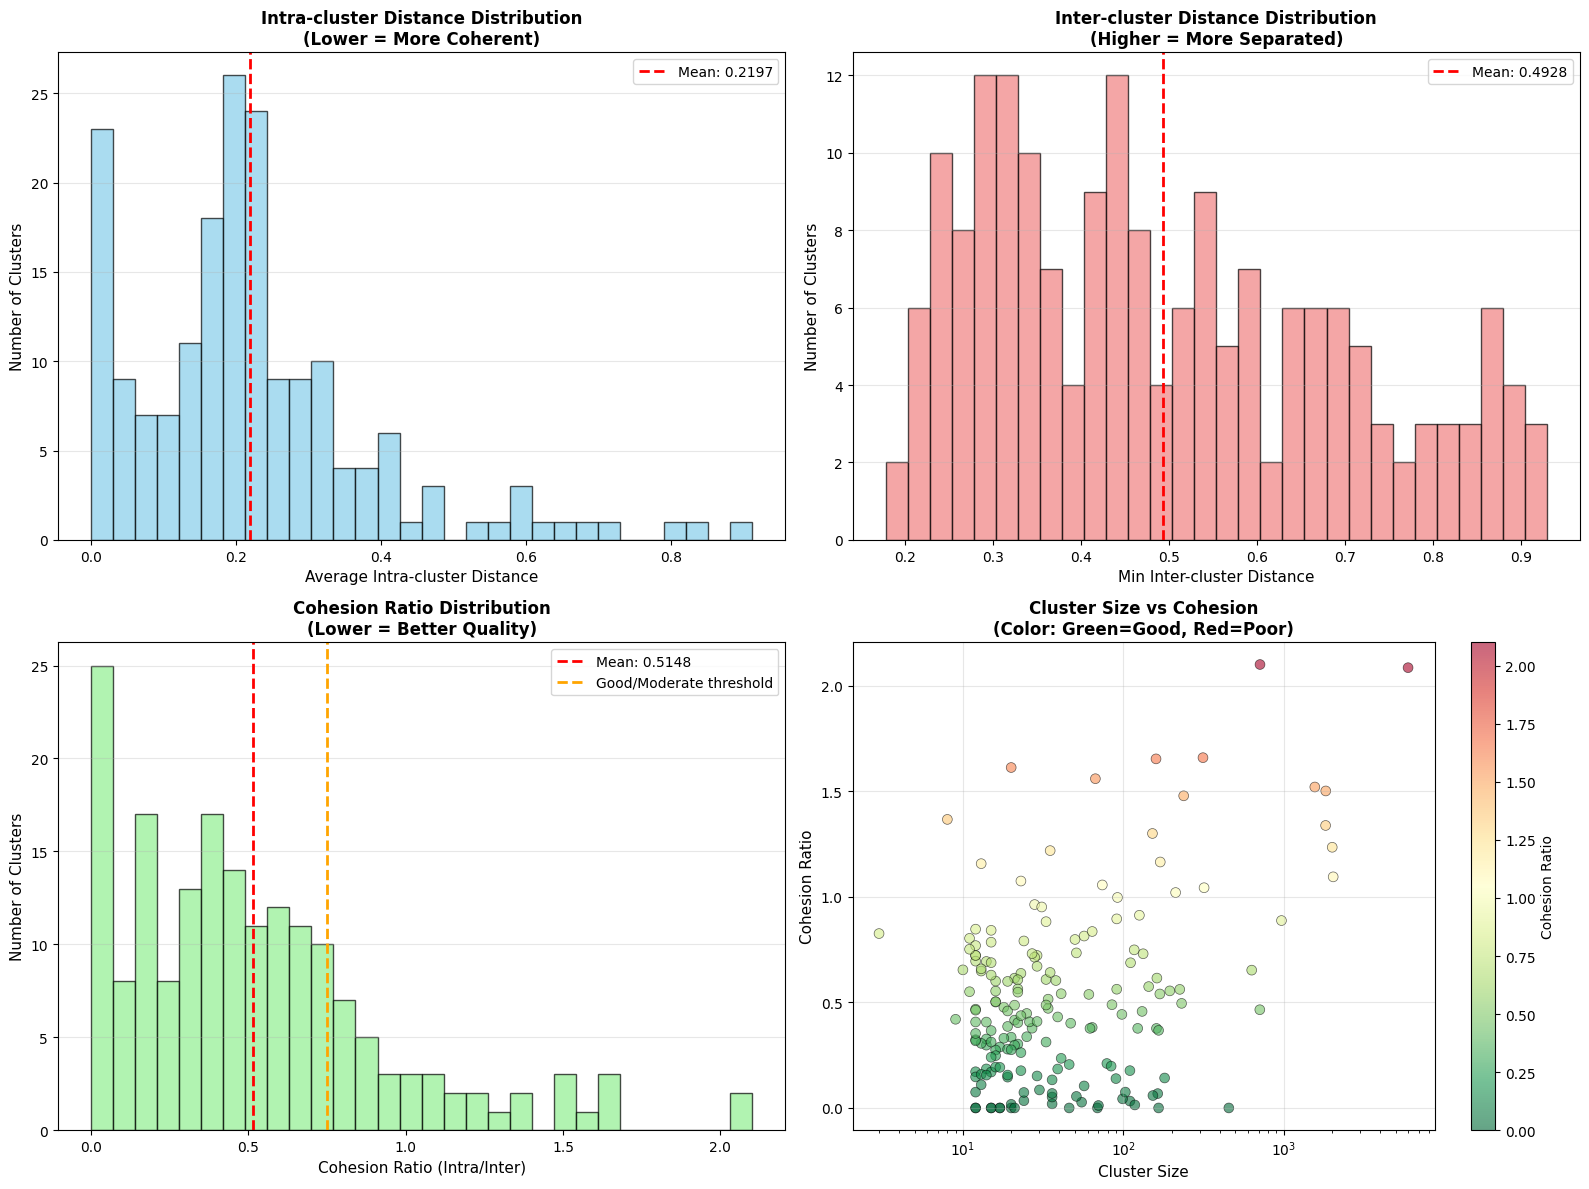


🏆 TOP 10 MOST COHERENT CLUSTERS (Lowest Cohesion Ratio):
 DBSCAN_Cluster  Size  Avg_Intra_Distance  Min_Inter_Distance  Cohesion_Ratio
              2    69                 0.0            0.636189             0.0
             17    20                 0.0            0.665203             0.0
             34    12                 0.0            0.739556             0.0
             60    17                 0.0            0.618379             0.0
             73   455                 0.0            0.328940             0.0
             76    46                 0.0            0.805982             0.0
            116    15                 0.0            0.233172             0.0
            130    17                 0.0            0.235234             0.0
            151    15                 0.0            0.304341             0.0
            169    21                 0.0            0.347205             0.0

⚠️  TOP 10 LEAST COHERENT CLUSTERS (Highest Cohesion Ratio):
 DBSCAN_Cluster  Size 

In [16]:
if len(results_valid) > 0:
    from scipy.spatial.distance import cdist
    
    print("=" * 70)
    print("CLUSTER COHERENCE ANALYSIS")
    print("=" * 70)
    print("Computing coherence metrics for each cluster...")
    
    df_clustered = product[product['DBSCAN_Cluster'] != -1].copy()
    coherence_results = []
    
    unique_clusters = sorted(df_clustered['DBSCAN_Cluster'].unique())
    
    # Convert features to dense for easier computation (or work with sparse)
    # For large datasets, we'll sample or work with sparse matrices
    
    for cluster_id in tqdm(unique_clusters, desc="Analyzing clusters"):
        cluster_mask = df_clustered['DBSCAN_Cluster'] == cluster_id
        cluster_indices = df_clustered[cluster_mask].index
        cluster_features = product_features[cluster_indices]
        
        cluster_size = len(cluster_indices)
        
        # Skip very small clusters for coherence calculation
        if cluster_size < 2:
            continue
        
        # 1. Intra-cluster cohesion (average pairwise distance within cluster)
        # For computational efficiency, sample if cluster is large
        if cluster_size > 100:
            sample_size = 100
            sample_indices = np.random.choice(cluster_size, sample_size, replace=False)
            cluster_features_sample = cluster_features[sample_indices]
        else:
            cluster_features_sample = cluster_features
        
        # Convert to dense for distance computation
        if hasattr(cluster_features_sample, 'toarray'):
            cluster_features_dense = cluster_features_sample.toarray()
        else:
            cluster_features_dense = cluster_features_sample
        
        # Compute pairwise cosine distances within cluster
        intra_distances = cdist(cluster_features_dense, cluster_features_dense, metric='cosine')
        # Take upper triangle (exclude diagonal and duplicates)
        intra_distances_flat = intra_distances[np.triu_indices_from(intra_distances, k=1)]
        avg_intra_distance = intra_distances_flat.mean() if len(intra_distances_flat) > 0 else 0
        
        # 2. Cluster centroid (mean of all points in cluster)
        cluster_centroid = cluster_features.mean(axis=0)
        if hasattr(cluster_centroid, 'A1'):
            cluster_centroid = cluster_centroid.A1  # Convert matrix to array
        
        # 3. Average distance to centroid
        if hasattr(cluster_features, 'toarray'):
            cluster_features_dense_full = cluster_features.toarray()
        else:
            cluster_features_dense_full = cluster_features
        
        centroid_distances = cdist(cluster_features_dense_full, cluster_centroid.reshape(1, -1), metric='cosine')
        avg_centroid_distance = centroid_distances.mean()
        
        # 4. Inter-cluster separation (distance to nearest other cluster)
        # Find centroid of nearest other cluster
        min_inter_distance = float('inf')
        for other_cluster_id in unique_clusters:
            if other_cluster_id == cluster_id:
                continue
            
            other_cluster_mask = df_clustered['DBSCAN_Cluster'] == other_cluster_id
            other_cluster_indices = df_clustered[other_cluster_mask].index
            other_cluster_features = product_features[other_cluster_indices]
            
            # Compute centroid of other cluster
            other_centroid = other_cluster_features.mean(axis=0)
            if hasattr(other_centroid, 'A1'):
                other_centroid = other_centroid.A1
            
            # Distance between centroids
            inter_distance = cdist(cluster_centroid.reshape(1, -1), 
                                  other_centroid.reshape(1, -1), 
                                  metric='cosine')[0, 0]
            
            min_inter_distance = min(min_inter_distance, inter_distance)
        
        # 5. Cohesion ratio (lower is better - tight cluster far from others)
        cohesion_ratio = avg_intra_distance / min_inter_distance if min_inter_distance > 0 else float('inf')
        
        coherence_results.append({
            'DBSCAN_Cluster': cluster_id,
            'Size': cluster_size,
            'Avg_Intra_Distance': avg_intra_distance,
            'Avg_Centroid_Distance': avg_centroid_distance,
            'Min_Inter_Distance': min_inter_distance,
            'Cohesion_Ratio': cohesion_ratio
        })
    
    coherence_df = pd.DataFrame(coherence_results)
    
    print("\n" + "=" * 70)
    print("COHERENCE STATISTICS")
    print("=" * 70)
    print(f"\nIntra-cluster Distance (lower = more coherent):")
    print(f"  Mean: {coherence_df['Avg_Intra_Distance'].mean():.4f}")
    print(f"  Median: {coherence_df['Avg_Intra_Distance'].median():.4f}")
    print(f"  Std: {coherence_df['Avg_Intra_Distance'].std():.4f}")
    
    print(f"\nInter-cluster Distance (higher = more separated):")
    print(f"  Mean: {coherence_df['Min_Inter_Distance'].mean():.4f}")
    print(f"  Median: {coherence_df['Min_Inter_Distance'].median():.4f}")
    print(f"  Std: {coherence_df['Min_Inter_Distance'].std():.4f}")
    
    print(f"\nCohesion Ratio (lower = better quality):")
    # Filter out inf values for statistics
    valid_ratios = coherence_df[coherence_df['Cohesion_Ratio'] != float('inf')]['Cohesion_Ratio']
    print(f"  Mean: {valid_ratios.mean():.4f}")
    print(f"  Median: {valid_ratios.median():.4f}")
    print(f"  Std: {valid_ratios.std():.4f}")
    
    print(f"\n📊 Cluster Quality Breakdown:")
    excellent = (valid_ratios < 0.5).sum()
    good = ((valid_ratios >= 0.5) & (valid_ratios < 0.75)).sum()
    moderate = ((valid_ratios >= 0.75) & (valid_ratios < 1.0)).sum()
    poor = (valid_ratios >= 1.0).sum()
    
    print(f"  Excellent (ratio < 0.5): {excellent} clusters ({excellent/len(valid_ratios)*100:.1f}%)")
    print(f"  Good (0.5 ≤ ratio < 0.75): {good} clusters ({good/len(valid_ratios)*100:.1f}%)")
    print(f"  Moderate (0.75 ≤ ratio < 1.0): {moderate} clusters ({moderate/len(valid_ratios)*100:.1f}%)")
    print(f"  Poor (ratio ≥ 1.0): {poor} clusters ({poor/len(valid_ratios)*100:.1f}%)")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Intra-cluster distances
    ax1 = axes[0, 0]
    ax1.hist(coherence_df['Avg_Intra_Distance'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(coherence_df['Avg_Intra_Distance'].mean(), color='red', linestyle='--', linewidth=2,
                label=f"Mean: {coherence_df['Avg_Intra_Distance'].mean():.4f}")
    ax1.set_xlabel('Average Intra-cluster Distance', fontsize=11)
    ax1.set_ylabel('Number of Clusters', fontsize=11)
    ax1.set_title('Intra-cluster Distance Distribution\n(Lower = More Coherent)', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Inter-cluster distances
    ax2 = axes[0, 1]
    ax2.hist(coherence_df['Min_Inter_Distance'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    ax2.axvline(coherence_df['Min_Inter_Distance'].mean(), color='red', linestyle='--', linewidth=2,
                label=f"Mean: {coherence_df['Min_Inter_Distance'].mean():.4f}")
    ax2.set_xlabel('Min Inter-cluster Distance', fontsize=11)
    ax2.set_ylabel('Number of Clusters', fontsize=11)
    ax2.set_title('Inter-cluster Distance Distribution\n(Higher = More Separated)', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Cohesion ratio
    ax3 = axes[1, 0]
    valid_coherence = coherence_df[coherence_df['Cohesion_Ratio'] != float('inf')]
    ax3.hist(valid_coherence['Cohesion_Ratio'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    ax3.axvline(valid_ratios.mean(), color='red', linestyle='--', linewidth=2,
                label=f"Mean: {valid_ratios.mean():.4f}")
    ax3.axvline(0.75, color='orange', linestyle='--', linewidth=2, label='Good/Moderate threshold')
    ax3.set_xlabel('Cohesion Ratio (Intra/Inter)', fontsize=11)
    ax3.set_ylabel('Number of Clusters', fontsize=11)
    ax3.set_title('Cohesion Ratio Distribution\n(Lower = Better Quality)', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Scatter: Cluster size vs coherence
    ax4 = axes[1, 1]
    valid_coherence = coherence_df[coherence_df['Cohesion_Ratio'] != float('inf')]
    scatter = ax4.scatter(valid_coherence['Size'], valid_coherence['Cohesion_Ratio'],
                         c=valid_coherence['Cohesion_Ratio'], cmap='RdYlGn_r',
                         s=50, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax4.set_xlabel('Cluster Size', fontsize=11)
    ax4.set_ylabel('Cohesion Ratio', fontsize=11)
    ax4.set_title('Cluster Size vs Cohesion\n(Color: Green=Good, Red=Poor)', fontsize=12, fontweight='bold')
    ax4.set_xscale('log')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Cohesion Ratio')
    
    plt.tight_layout()
    plt.show()
    
    # Show best and worst clusters
    print("\n" + "=" * 70)
    print("🏆 TOP 10 MOST COHERENT CLUSTERS (Lowest Cohesion Ratio):")
    print("=" * 70)
    best_clusters = valid_coherence.nsmallest(10, 'Cohesion_Ratio')[
        ['DBSCAN_Cluster', 'Size', 'Avg_Intra_Distance', 'Min_Inter_Distance', 'Cohesion_Ratio']
    ]
    print(best_clusters.to_string(index=False))
    
    print("\n" + "=" * 70)
    print("⚠️  TOP 10 LEAST COHERENT CLUSTERS (Highest Cohesion Ratio):")
    print("=" * 70)
    worst_clusters = valid_coherence.nlargest(10, 'Cohesion_Ratio')[
        ['DBSCAN_Cluster', 'Size', 'Avg_Intra_Distance', 'Min_Inter_Distance', 'Cohesion_Ratio']
    ]
    print(worst_clusters.to_string(index=False))
    
    # Save results
    coherence_df.to_csv('cluster_coherence_analysis.csv', index=False)
    print("\n✓ Saved: cluster_coherence_analysis.csv")
    
    print("\n" + "=" * 70)
    print("INTERPRETATION:")
    print("=" * 70)
    print("  • Intra-cluster distance: How similar products are within a cluster")
    print("  • Inter-cluster distance: How different clusters are from each other")
    print("  • Cohesion ratio < 0.75: Well-separated, coherent clusters")
    print("  • Cohesion ratio ≥ 1.0: Clusters may overlap or be diffuse")
    print("=" * 70)

## 8. Sample Cluster Examples

Examine actual product titles to validate semantic coherence.

In [14]:
if len(results_valid) > 0 and len(purity_df) > 0:
    # High purity cluster
    high_purity = purity_df.nlargest(1, 'Purity').iloc[0]
    cluster_id = high_purity['DBSCAN_Cluster']
    
    print("=" * 70)
    print(f"EXAMPLE 1: High-Purity Cluster (DBSCAN Cluster {cluster_id})")
    print(f"Purity: {high_purity['Purity']:.3f} | Size: {high_purity['Size']} products")
    print("=" * 70)
    
    sample_titles = product[product['DBSCAN_Cluster'] == cluster_id]['Product Title'].head(15)
    for i, title in enumerate(sample_titles, 1):
        print(f"{i:2d}. {title}")
    
    # Merged cluster
    if (purity_df['Num_GT_Merged'] >= 3).any():
        merged = purity_df[purity_df['Num_GT_Merged'] >= 3].nlargest(1, 'Size').iloc[0]
        cluster_id = merged['DBSCAN_Cluster']
        
        print(f"\n\n" + "=" * 70)
        print(f"EXAMPLE 2: Merged Cluster (DBSCAN Cluster {cluster_id})")
        print(f"Purity: {merged['Purity']:.3f} | Size: {merged['Size']} | Merges {merged['Num_GT_Merged']} GT clusters")
        print("=" * 70)
        
        sample_titles = product[product['DBSCAN_Cluster'] == cluster_id]['Product Title'].sample(min(15, merged['Size']))
        for i, title in enumerate(sample_titles, 1):
            print(f"{i:2d}. {title}")
    
    # Noise examples
    noise_products = product[product['DBSCAN_Cluster'] == -1]
    if len(noise_products) > 0:
        print(f"\n\n" + "=" * 70)
        print(f"EXAMPLE 3: Noise Points ({len(noise_products)} total)")
        print("=" * 70)
        
        sample_noise = noise_products['Product Title'].sample(min(15, len(noise_products)))
        for i, title in enumerate(sample_noise, 1):
            print(f"{i:2d}. {title}")

EXAMPLE 1: High-Purity Cluster (DBSCAN Cluster 67.0)
Purity: 0.417 | Size: 12.0 products
 1. canon ixus 185 camera
 2. canon powershot sx730 hs camera silver
 3. canon powershot sx730 hs camera silver
 4. canon powershot sx730 hs camera
 5. canon powershot sx730 hs digitial camera silver 1792c011aa co64751
 6. canon ixus 285 hs silver
 7. canon ixus 285 camera silver 1079c007
 8. canon ixus 285 hs camera 20mp 12x wifi
 9. canon ixus 285 silver 1079c007 mw01
10. canon ixus 285 camera silver 1079c007
11. canon powershot sx740 hs silver
12. canon ixus 175 silver


EXAMPLE 2: Merged Cluster (DBSCAN Cluster 24.0)
Purity: 0.002 | Size: 5966.0 | Merges 3163.0 GT clusters
 1. swan sm22130cn solo microwave cream
 2. gorenje rb60299obl retro fridge
 3. iceking cfap66w 66litre a chest freezer
 4. swan 5r11035gn under counter fridge green
 5. siemens kg34nnw30g iq 300 60cm freestanding frost free fridge freezer white
 6. neff integrierter k hlschrank softclose ki8423d40
 7. hoover hvbfp6182w 60cm 

## 9. Final Summary & Conclusions

In [15]:
if len(results_valid) > 0:
    print("=" * 100)
    print("FINAL EVALUATION SUMMARY")
    print("=" * 100)
    
    print(f"\n🔧 SELECTED PARAMETERS:")
    print(f"  eps: {best['eps']:.4f}")
    print(f"  min_samples: {int(best['min_samples'])}")
    
    print(f"\n📊 CLUSTERING RESULTS:")
    print(f"  Ground Truth Clusters: {product[' Cluster ID'].nunique()}")
    print(f"  DBSCAN Clusters: {int(best['n_clusters'])}")
    print(f"  Reduction: {(1 - int(best['n_clusters'])/product[' Cluster ID'].nunique())*100:.1f}%")
    
    print(f"\n🎯 EXTERNAL VALIDATION (vs Ground Truth):")
    print(f"  ARI (Adjusted Rand Index): {best['ari']:.4f}")
    print(f"  NMI (Normalized Mutual Info): {best['nmi']:.4f}")
    print(f"  V-Measure: {best['v_measure']:.4f}")
    print(f"  Homogeneity: {best['homogeneity']:.4f}")
    print(f"  Completeness: {best['completeness']:.4f}")
    
    print(f"\n📈 INTERNAL QUALITY:")
    print(f"  Silhouette Score: {best['silhouette']:.4f}")
    print(f"  Davies-Bouldin Index: {best['davies_bouldin']:.4f}")
    
    print(f"\n🔴 NOISE HANDLING:")
    print(f"  Noise Points: {int(best['n_noise']):,} ({best['noise_ratio']*100:.1f}%)")
    print(f"  Clustered Points: {len(product) - int(best['n_noise']):,} ({(1-best['noise_ratio'])*100:.1f}%)")
    
    print(f"\n💎 CLUSTER PURITY:")
    print(f"  Average Purity: {purity_df['Purity'].mean():.3f}")
    print(f"  High Purity (≥0.9): {(purity_df['Purity'] >= 0.9).mean()*100:.1f}% of clusters")
    
    print(f"\n💡 INTERPRETATION:")
    if best['ari'] > 0.5:
        print(f"  ✅ EXCELLENT: DBSCAN successfully clusters similar products")
    elif best['ari'] > 0.3:
        print(f"  ✓ GOOD: DBSCAN captures meaningful product similarities")
    else:
        print(f"  ⚠️ MODERATE: DBSCAN partially captures product similarities")
    
    if purity_df['Purity'].mean() > 0.8:
        print(f"  ✅ High cluster purity indicates semantically coherent clusters")
    
    if best['noise_ratio'] < 0.3:
        print(f"  ✅ Reasonable noise ratio - most products are clustered")
    elif best['noise_ratio'] < 0.5:
        print(f"  ✓ Moderate noise ratio - acceptable for density-based clustering")
    else:
        print(f"  ⚠️ High noise ratio - consider adjusting parameters")
    
    print(f"\n🎓 CONCLUSION:")
    print(f"  DBSCAN {'CAN' if best['ari'] > 0.3 else 'PARTIALLY CAN'} cluster similar product titles together.")
    print(f"  The algorithm finds {int(best['n_clusters'])} natural clusters with {purity_df['Purity'].mean():.1%} average purity.")
    print(f"  Trade-off: Higher cluster quality vs lower coverage (noise).")
    
    print("\n" + "=" * 100)
    print("✅ EVALUATION COMPLETE")
    print("=" * 100)
else:
    print("\n⚠️ Evaluation incomplete - no valid parameters found.")

FINAL EVALUATION SUMMARY

🔧 SELECTED PARAMETERS:
  eps: 0.2208
  min_samples: 12

📊 CLUSTERING RESULTS:
  Ground Truth Clusters: 13233
  DBSCAN Clusters: 183
  Reduction: 98.6%

🎯 EXTERNAL VALIDATION (vs Ground Truth):
  ARI (Adjusted Rand Index): 0.0009
  NMI (Normalized Mutual Info): 0.4448
  V-Measure: 0.4448
  Homogeneity: 0.3030
  Completeness: 0.8359

📈 INTERNAL QUALITY:
  Silhouette Score: 0.0751
  Davies-Bouldin Index: 1.5663

🔴 NOISE HANDLING:
  Noise Points: 7,565 (21.4%)
  Clustered Points: 27,746 (78.6%)

💎 CLUSTER PURITY:
  Average Purity: 0.084
  High Purity (≥0.9): 0.0% of clusters

💡 INTERPRETATION:
  ⚠️ MODERATE: DBSCAN partially captures product similarities
  ✅ Reasonable noise ratio - most products are clustered

🎓 CONCLUSION:
  DBSCAN PARTIALLY CAN cluster similar product titles together.
  The algorithm finds 183 natural clusters with 8.4% average purity.
  Trade-off: Higher cluster quality vs lower coverage (noise).

✅ EVALUATION COMPLETE


---

## 10. Qualitative Cluster Evaluation

Beyond quantitative metrics, let's manually inspect clusters to assess semantic coherence.

### 10.1 Cluster Size Distribution

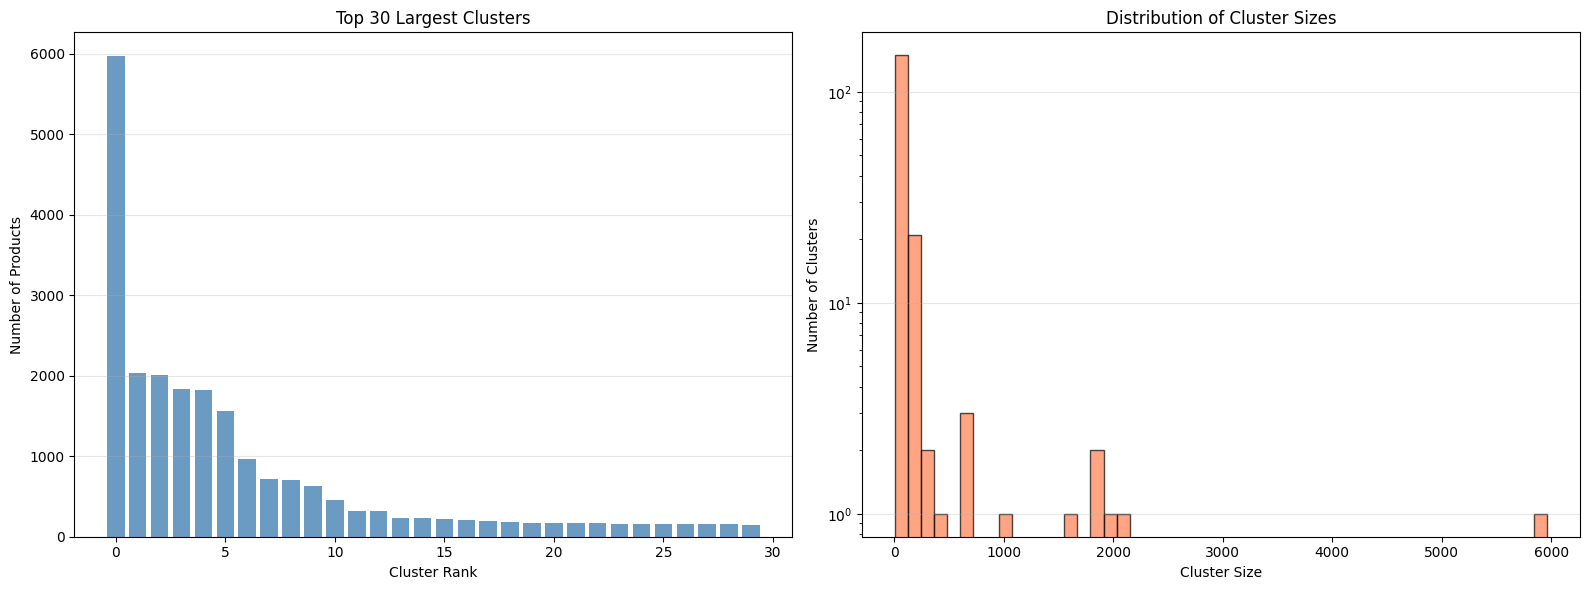

CLUSTER SIZE STATISTICS
Total clusters (excluding noise): 183
Largest cluster: 5966 products
Smallest cluster: 3 products
Mean cluster size: 151.62 products
Median cluster size: 27 products

Cluster size percentiles:
  25th percentile: 16 products
  50th percentile: 27 products
  75th percentile: 88 products
  90th percentile: 179 products
  95th percentile: 614 products
  99th percentile: 2013 products


In [17]:
if len(results_valid) > 0:
    # Analyze cluster size distribution
    cluster_sizes = product['DBSCAN_Cluster'].value_counts().sort_values(ascending=False)
    cluster_sizes_no_noise = cluster_sizes[cluster_sizes.index != -1]

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Top 30 largest clusters
    ax1 = axes[0]
    top_30 = cluster_sizes_no_noise.head(30)
    ax1.bar(range(len(top_30)), top_30.values, color='steelblue', alpha=0.8)
    ax1.set_xlabel('Cluster Rank')
    ax1.set_ylabel('Number of Products')
    ax1.set_title('Top 30 Largest Clusters')
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Cluster size histogram
    ax2 = axes[1]
    ax2.hist(cluster_sizes_no_noise.values, bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Cluster Size')
    ax2.set_ylabel('Number of Clusters')
    ax2.set_title('Distribution of Cluster Sizes')
    ax2.set_yscale('log')  # Log scale to see small clusters
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistics
    print("=" * 80)
    print("CLUSTER SIZE STATISTICS")
    print("=" * 80)
    print(f"Total clusters (excluding noise): {len(cluster_sizes_no_noise)}")
    print(f"Largest cluster: {cluster_sizes_no_noise.max()} products")
    print(f"Smallest cluster: {cluster_sizes_no_noise.min()} products")
    print(f"Mean cluster size: {cluster_sizes_no_noise.mean():.2f} products")
    print(f"Median cluster size: {cluster_sizes_no_noise.median():.0f} products")
    print(f"\nCluster size percentiles:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"  {p}th percentile: {cluster_sizes_no_noise.quantile(p/100):.0f} products")
    print("=" * 80)

### 10.2 Inspect Sample Clusters - Large Clusters

Let's examine large clusters to see if they make sense.

In [18]:
if len(results_valid) > 0:
    # Function to display cluster details
    def inspect_cluster(cluster_id, n_samples=10):
        """Display detailed information about a specific cluster"""
        cluster_data = product[product['DBSCAN_Cluster'] == cluster_id]
        
        print("=" * 100)
        print(f"CLUSTER {cluster_id} | Size: {len(cluster_data)} products")
        print("=" * 100)
        
        # Show ground truth cluster distribution within this DBSCAN cluster
        gt_distribution = cluster_data[' Cluster ID'].value_counts().head(5)
        print(f"\nTop 5 Ground Truth Clusters in this DBSCAN cluster:")
        for gt_id, count in gt_distribution.items():
            pct = (count / len(cluster_data)) * 100
            gt_label = cluster_data[cluster_data[' Cluster ID'] == gt_id][' Cluster Label'].iloc[0]
            print(f"  • GT Cluster {gt_id} ({gt_label}): {count} products ({pct:.1f}%)")
        
        # Sample products
        print(f"\n📦 Sample Products (showing {min(n_samples, len(cluster_data))} of {len(cluster_data)}):")
        print("-" * 100)
        
        sample = cluster_data.sample(n=min(n_samples, len(cluster_data)), random_state=42)
        for idx, (_, row) in enumerate(sample.iterrows(), 1):
            print(f"{idx:2d}. {row['Product Title']}")
            print(f"    └─ GT: Cluster {row[' Cluster ID']} ({row[' Cluster Label']})")
        
        print("=" * 100)
        return cluster_data

    # Inspect the 5 largest clusters
    print("\n🔍 INSPECTING TOP 5 LARGEST CLUSTERS\n")
    top_5_clusters = cluster_sizes_no_noise.head(5).index

    for i, cluster_id in enumerate(top_5_clusters, 1):
        print(f"\n{'#' * 100}")
        print(f"#{' ' * 43}LARGE CLUSTER #{i}{' ' * 43}#")
        print(f"{'#' * 100}\n")
        _ = inspect_cluster(cluster_id, n_samples=15)


🔍 INSPECTING TOP 5 LARGEST CLUSTERS


####################################################################################################
#                                           LARGE CLUSTER #1                                           #
####################################################################################################

CLUSTER 24 | Size: 5966 products

Top 5 Ground Truth Clusters in this DBSCAN cluster:
  • GT Cluster 44038 (Bosch KGN34NW3AG White): 12 products (0.2%)
  • GT Cluster 44050 (Bosch KGN36NW30G White): 12 products (0.2%)
  • GT Cluster 44148 (Hotpoint FFU4DX Stainless Steel): 10 products (0.2%)
  • GT Cluster 46114 (Fridgemaster MUL49102 White): 10 products (0.2%)
  • GT Cluster 44043 (Bosch KGN36HI32 Stainless Steel): 10 products (0.2%)

📦 Sample Products (showing 15 of 5966):
----------------------------------------------------------------------------------------------------
 1. siemens einbau k hlautomat flachscharnier technik softeinzug mit t r

### 10.3 Inspect Sample Clusters - Medium & Small Clusters

Check if smaller clusters have better coherence.

In [19]:
if len(results_valid) > 0:
    # Sample clusters from different size ranges
    print("🔍 INSPECTING CLUSTERS FROM DIFFERENT SIZE RANGES\n")

    # Define size ranges
    size_ranges = [
        ("Medium (10-30 products)", 10, 30, 3),
        ("Small (4-9 products)", 4, 9, 3),
        ("Tiny (3 products)", 3, 3, 2)
    ]

    for range_name, min_size, max_size, n_samples_to_show in size_ranges:
        # Find clusters in this range
        clusters_in_range = cluster_sizes_no_noise[
            (cluster_sizes_no_noise >= min_size) & 
            (cluster_sizes_no_noise <= max_size)
        ]
        
        if len(clusters_in_range) == 0:
            print(f"\n⚠️  No clusters found in range: {range_name}")
            continue
        
        print(f"\n{'#' * 100}")
        print(f"#{' ' * 35}{range_name.upper()}{' ' * (63-len(range_name))}#")
        print(f"#{' ' * 40}({len(clusters_in_range)} clusters){' ' * 40}#")
        print(f"{'#' * 100}\n")
        
        # Sample random clusters from this range
        sample_clusters = clusters_in_range.sample(n=min(n_samples_to_show, len(clusters_in_range)), random_state=42)
        
        for i, (cluster_id, size) in enumerate(sample_clusters.items(), 1):
            print(f"\n--- Sample {i}/{min(n_samples_to_show, len(clusters_in_range))} ---\n")
            _ = inspect_cluster(cluster_id, n_samples=size)  # Show all products in small clusters

🔍 INSPECTING CLUSTERS FROM DIFFERENT SIZE RANGES


####################################################################################################
#                                   MEDIUM (10-30 PRODUCTS)                                        #
#                                        (96 clusters)                                        #
####################################################################################################


--- Sample 1/3 ---

CLUSTER 34 | Size: 12 products

Top 5 Ground Truth Clusters in this DBSCAN cluster:
  • GT Cluster 1147 (Zte Blade V7 Lite Dual SIM): 1 products (8.3%)
  • GT Cluster 38933 (Nikon CoolPix W100): 1 products (8.3%)
  • GT Cluster 38992 (Olympus PEN E-PL9 + 14-42mm EZ): 1 products (8.3%)
  • GT Cluster 41882 (Samsung WW90J5455MW): 1 products (8.3%)
  • GT Cluster 41948 (Samsung WW80J5555EX): 1 products (8.3%)

📦 Sample Products (showing 12 of 12):
-------------------------------------------------------------------------------

### 10.4 Analyze Noise Points

Are products labeled as "noise" genuinely unique/outliers?

In [20]:
if len(results_valid) > 0:
    # Analyze noise points
    noise_data = product[product['DBSCAN_Cluster'] == -1]

    print("=" * 100)
    print("NOISE POINT ANALYSIS")
    print("=" * 100)
    print(f"Total noise points: {len(noise_data)} ({(len(noise_data)/len(product)*100):.1f}%)")

    # What ground truth clusters do noise points belong to?
    noise_gt_distribution = noise_data[' Cluster ID'].value_counts()

    print(f"\n📊 Ground Truth Cluster Distribution of Noise Points:")
    print(f"   Unique GT clusters among noise: {len(noise_gt_distribution)}")
    print(f"   Top 10 GT clusters in noise:")
    for i, (gt_id, count) in enumerate(noise_gt_distribution.head(10).items(), 1):
        pct = (count / len(noise_data)) * 100
        gt_label = noise_data[noise_data[' Cluster ID'] == gt_id][' Cluster Label'].iloc[0]
        print(f"   {i:2d}. GT Cluster {gt_id} ({gt_label}): {count} products ({pct:.1f}%)")

    # Sample random noise points
    print(f"\n🔍 Sample Noise Points (Random 20):")
    print("-" * 100)
    noise_sample = noise_data.sample(n=min(20, len(noise_data)), random_state=42)

    for idx, (_, row) in enumerate(noise_sample.iterrows(), 1):
        print(f"{idx:2d}. {row['Product Title']}")
        print(f"    └─ GT: Cluster {row[' Cluster ID']} ({row[' Cluster Label']})")

    print("=" * 100)

    print("\n💡 INTERPRETATION:")
    print("   • Are these products genuinely unique/sparse in title text?")
    print("   • Do they have very specific/detailed titles?")
    print("   • Are they from small GT clusters that don't have enough similar neighbors?")
    print("=" * 100)

NOISE POINT ANALYSIS
Total noise points: 7565 (21.4%)

📊 Ground Truth Cluster Distribution of Noise Points:
   Unique GT clusters among noise: 4877
   Top 10 GT clusters in noise:
    1. GT Cluster 46133 (Samsung RR39M7340BC Black): 12 products (0.2%)
    2. GT Cluster 46136 (Samsung RR39M7340SA Silver): 10 products (0.1%)
    3. GT Cluster 46222 (Samsung RR39M73407F Stainless Steel): 9 products (0.1%)
    4. GT Cluster 38848 (Canon IXUS 185): 9 products (0.1%)
    5. GT Cluster 46124 (Hisense RL170D4BC2 Stainless Steel): 9 products (0.1%)
    6. GT Cluster 40486 (Bosch SKS62E22EU White): 8 products (0.1%)
    7. GT Cluster 38878 (Canon PowerShot SX60 HS): 8 products (0.1%)
    8. GT Cluster 6 (Samsung Galaxy S8 64GB): 8 products (0.1%)
    9. GT Cluster 38939 (Olympus E-PL8 + 14-42mm): 7 products (0.1%)
   10. GT Cluster 38849 (Canon PowerShot SX730 HS): 7 products (0.1%)

🔍 Sample Noise Points (Random 20):
------------------------------------------------------------------------------

### 10.5 Enhanced Cluster Purity & Homogeneity Analysis

Measure how "pure" each cluster is relative to ground truth with detailed visualizations.

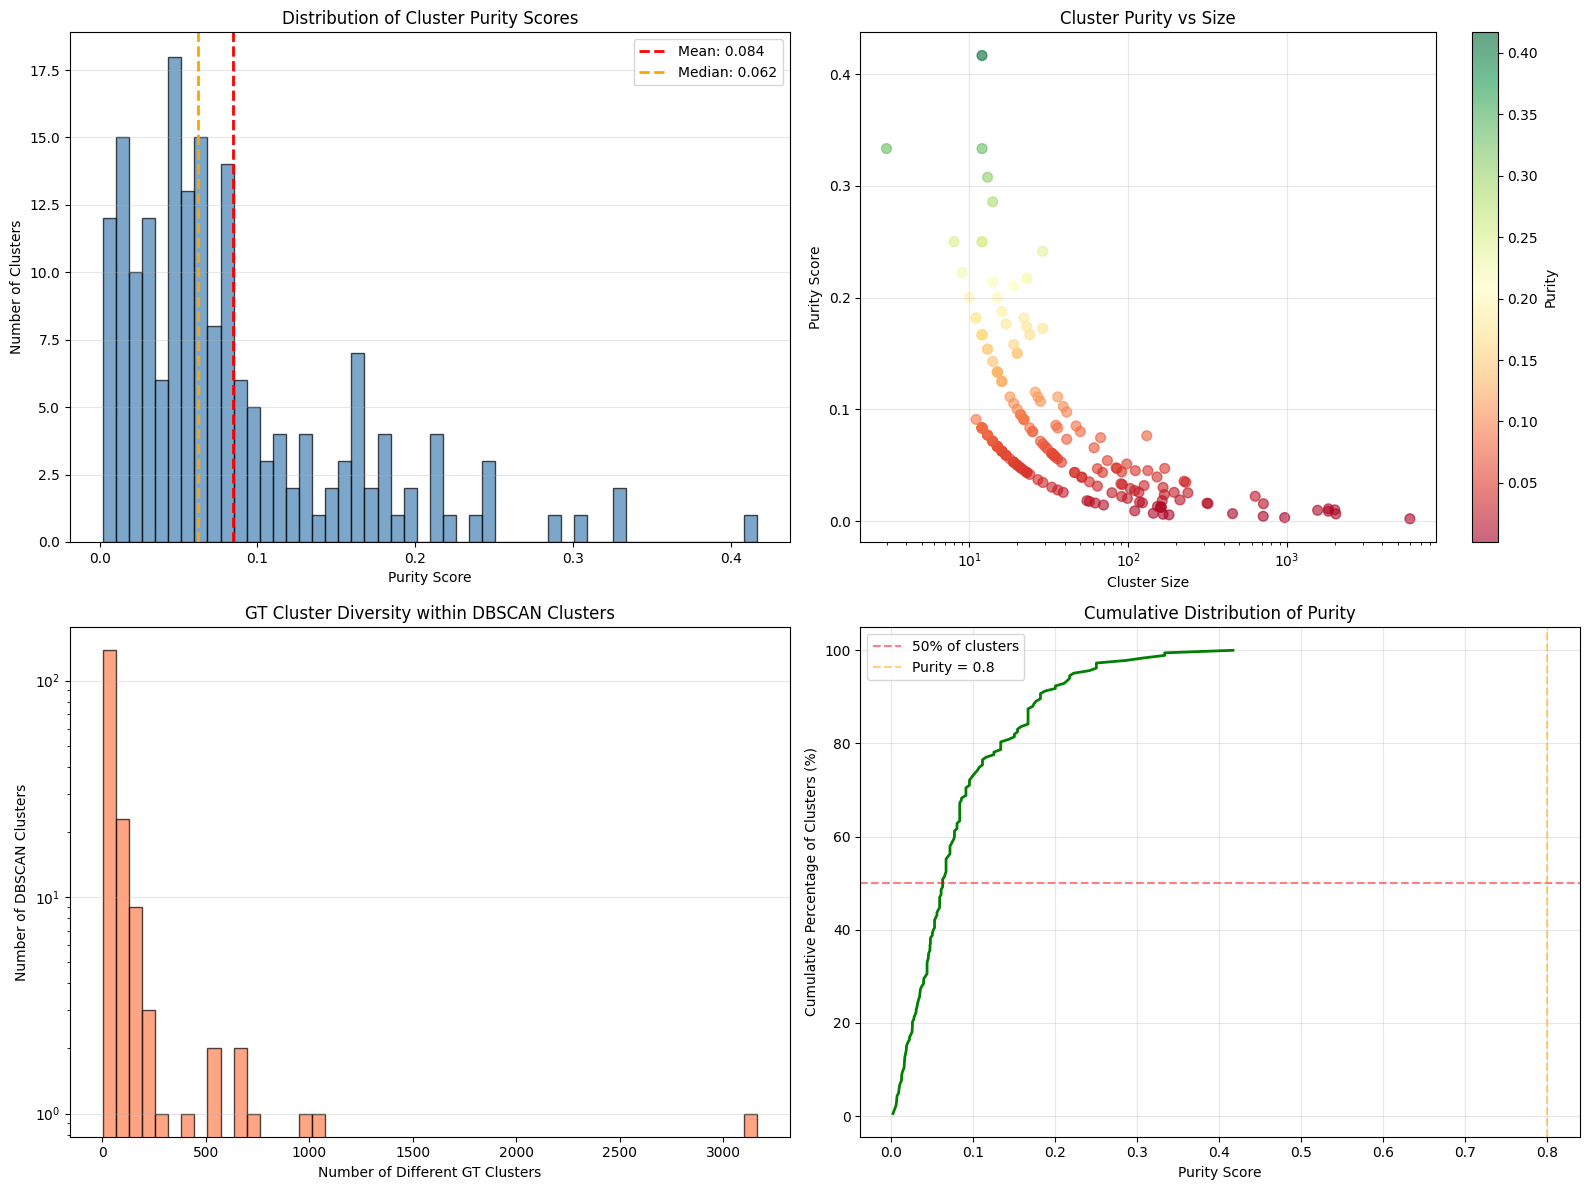

ENHANCED CLUSTER PURITY ANALYSIS
Total clusters analyzed: 183

Purity Statistics:
  Mean purity: 0.084
  Median purity: 0.062
  Std deviation: 0.073

Purity Thresholds:
  Clusters with purity ≥ 0.9: 0 (0.0%)
  Clusters with purity ≥ 0.8: 0 (0.0%)
  Clusters with purity ≥ 0.7: 0 (0.0%)
  Clusters with purity ≥ 0.5: 0 (0.0%)

GT Cluster Diversity:
  Mean GT clusters per DBSCAN cluster: 88.7
  Median GT clusters per DBSCAN cluster: 23
  Max GT clusters in one DBSCAN cluster: 3163

🏆 TOP 10 MOST PURE CLUSTERS:
----------------------------------------------------------------------------------------------------
    67 | Size:  12 | Purity: 0.417 | Dominant: Canon IXUS 285 HS
    63 | Size:  12 | Purity: 0.333 | Dominant: AMD Sempron Sempron 2650 Radeon R3 Series 1.45GHz Box
   176 | Size:   3 | Purity: 0.333 | Dominant: Beko UL584APW White
   134 | Size:  13 | Purity: 0.308 | Dominant: Fridgemaster MUZ4965 White
    28 | Size:  14 | Purity: 0.286 | Dominant: Sony Cyber-shot DSC-RX100 II
    

In [21]:
if len(results_valid) > 0 and len(purity_df) > 0:
    # Calculate enhanced purity metrics
    # Purity = (size of largest GT cluster) / (total cluster size)

    enhanced_purity_data = []

    for cluster_id in cluster_sizes_no_noise.index:
        cluster_data = product[product['DBSCAN_Cluster'] == cluster_id]
        
        # Get ground truth distribution
        gt_distribution = cluster_data[' Cluster ID'].value_counts()
        
        # Calculate purity
        largest_gt_count = gt_distribution.max()
        cluster_size = len(cluster_data)
        purity = largest_gt_count / cluster_size
        
        # Get dominant GT cluster info
        dominant_gt_id = gt_distribution.idxmax()
        dominant_gt_label = cluster_data[cluster_data[' Cluster ID'] == dominant_gt_id][' Cluster Label'].iloc[0]
        
        enhanced_purity_data.append({
            'DBSCAN_Cluster': cluster_id,
            'Size': cluster_size,
            'Purity': purity,
            'Dominant_GT_ID': dominant_gt_id,
            'Dominant_GT_Label': dominant_gt_label,
            'Dominant_GT_Count': largest_gt_count,
            'Num_GT_Clusters': len(gt_distribution)
        })

    enhanced_purity_df = pd.DataFrame(enhanced_purity_data)

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Purity distribution
    ax1 = axes[0, 0]
    ax1.hist(enhanced_purity_df['Purity'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(enhanced_purity_df['Purity'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {enhanced_purity_df["Purity"].mean():.3f}')
    ax1.axvline(enhanced_purity_df['Purity'].median(), color='orange', linestyle='--', linewidth=2, 
                label=f'Median: {enhanced_purity_df["Purity"].median():.3f}')
    ax1.set_xlabel('Purity Score')
    ax1.set_ylabel('Number of Clusters')
    ax1.set_title('Distribution of Cluster Purity Scores')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Purity vs Cluster Size
    ax2 = axes[0, 1]
    scatter = ax2.scatter(enhanced_purity_df['Size'], enhanced_purity_df['Purity'], alpha=0.6, s=50, 
                         c=enhanced_purity_df['Purity'], cmap='RdYlGn')
    ax2.set_xlabel('Cluster Size')
    ax2.set_ylabel('Purity Score')
    ax2.set_title('Cluster Purity vs Size')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Purity')

    # Plot 3: Number of GT clusters per DBSCAN cluster
    ax3 = axes[1, 0]
    ax3.hist(enhanced_purity_df['Num_GT_Clusters'], bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax3.set_xlabel('Number of Different GT Clusters')
    ax3.set_ylabel('Number of DBSCAN Clusters')
    ax3.set_title('GT Cluster Diversity within DBSCAN Clusters')
    ax3.set_yscale('log')
    ax3.grid(axis='y', alpha=0.3)

    # Plot 4: Cumulative purity
    ax4 = axes[1, 1]
    sorted_purity = np.sort(enhanced_purity_df['Purity'])
    cumulative = np.arange(1, len(sorted_purity) + 1) / len(sorted_purity) * 100
    ax4.plot(sorted_purity, cumulative, linewidth=2, color='green')
    ax4.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% of clusters')
    ax4.axvline(0.8, color='orange', linestyle='--', alpha=0.5, label='Purity = 0.8')
    ax4.set_xlabel('Purity Score')
    ax4.set_ylabel('Cumulative Percentage of Clusters (%)')
    ax4.set_title('Cumulative Distribution of Purity')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistics
    print("=" * 100)
    print("ENHANCED CLUSTER PURITY ANALYSIS")
    print("=" * 100)
    print(f"Total clusters analyzed: {len(enhanced_purity_df)}")
    print(f"\nPurity Statistics:")
    print(f"  Mean purity: {enhanced_purity_df['Purity'].mean():.3f}")
    print(f"  Median purity: {enhanced_purity_df['Purity'].median():.3f}")
    print(f"  Std deviation: {enhanced_purity_df['Purity'].std():.3f}")
    print(f"\nPurity Thresholds:")
    for threshold in [0.9, 0.8, 0.7, 0.5]:
        count = (enhanced_purity_df['Purity'] >= threshold).sum()
        pct = (count / len(enhanced_purity_df)) * 100
        print(f"  Clusters with purity ≥ {threshold}: {count} ({pct:.1f}%)")

    print(f"\nGT Cluster Diversity:")
    print(f"  Mean GT clusters per DBSCAN cluster: {enhanced_purity_df['Num_GT_Clusters'].mean():.1f}")
    print(f"  Median GT clusters per DBSCAN cluster: {enhanced_purity_df['Num_GT_Clusters'].median():.0f}")
    print(f"  Max GT clusters in one DBSCAN cluster: {enhanced_purity_df['Num_GT_Clusters'].max()}")

    # Show most pure clusters
    print(f"\n🏆 TOP 10 MOST PURE CLUSTERS:")
    print("-" * 100)
    top_pure = enhanced_purity_df.nlargest(10, 'Purity')
    for i, row in top_pure.iterrows():
        print(f"  {row['DBSCAN_Cluster']:4d} | Size: {row['Size']:3d} | Purity: {row['Purity']:.3f} | "
              f"Dominant: {row['Dominant_GT_Label']}")

    # Show least pure (most mixed) clusters
    print(f"\n⚠️  TOP 10 LEAST PURE (MOST MIXED) CLUSTERS:")
    print("-" * 100)
    least_pure = enhanced_purity_df.nsmallest(10, 'Purity')
    for i, row in least_pure.iterrows():
        print(f"  {row['DBSCAN_Cluster']:4d} | Size: {row['Size']:3d} | Purity: {row['Purity']:.3f} | "
              f"{row['Num_GT_Clusters']} GT clusters mixed")

    print("=" * 100)

### 10.6 Word Cloud Analysis - Visualize Cluster Themes

Generate word clouds for selected clusters to see common terms.

🎨 Generating word clouds for top 6 largest clusters...

  Generating word cloud for cluster 24...
  Generating word cloud for cluster 55...
  Generating word cloud for cluster 0...
  Generating word cloud for cluster 12...
  Generating word cloud for cluster 124...
  Generating word cloud for cluster 47...


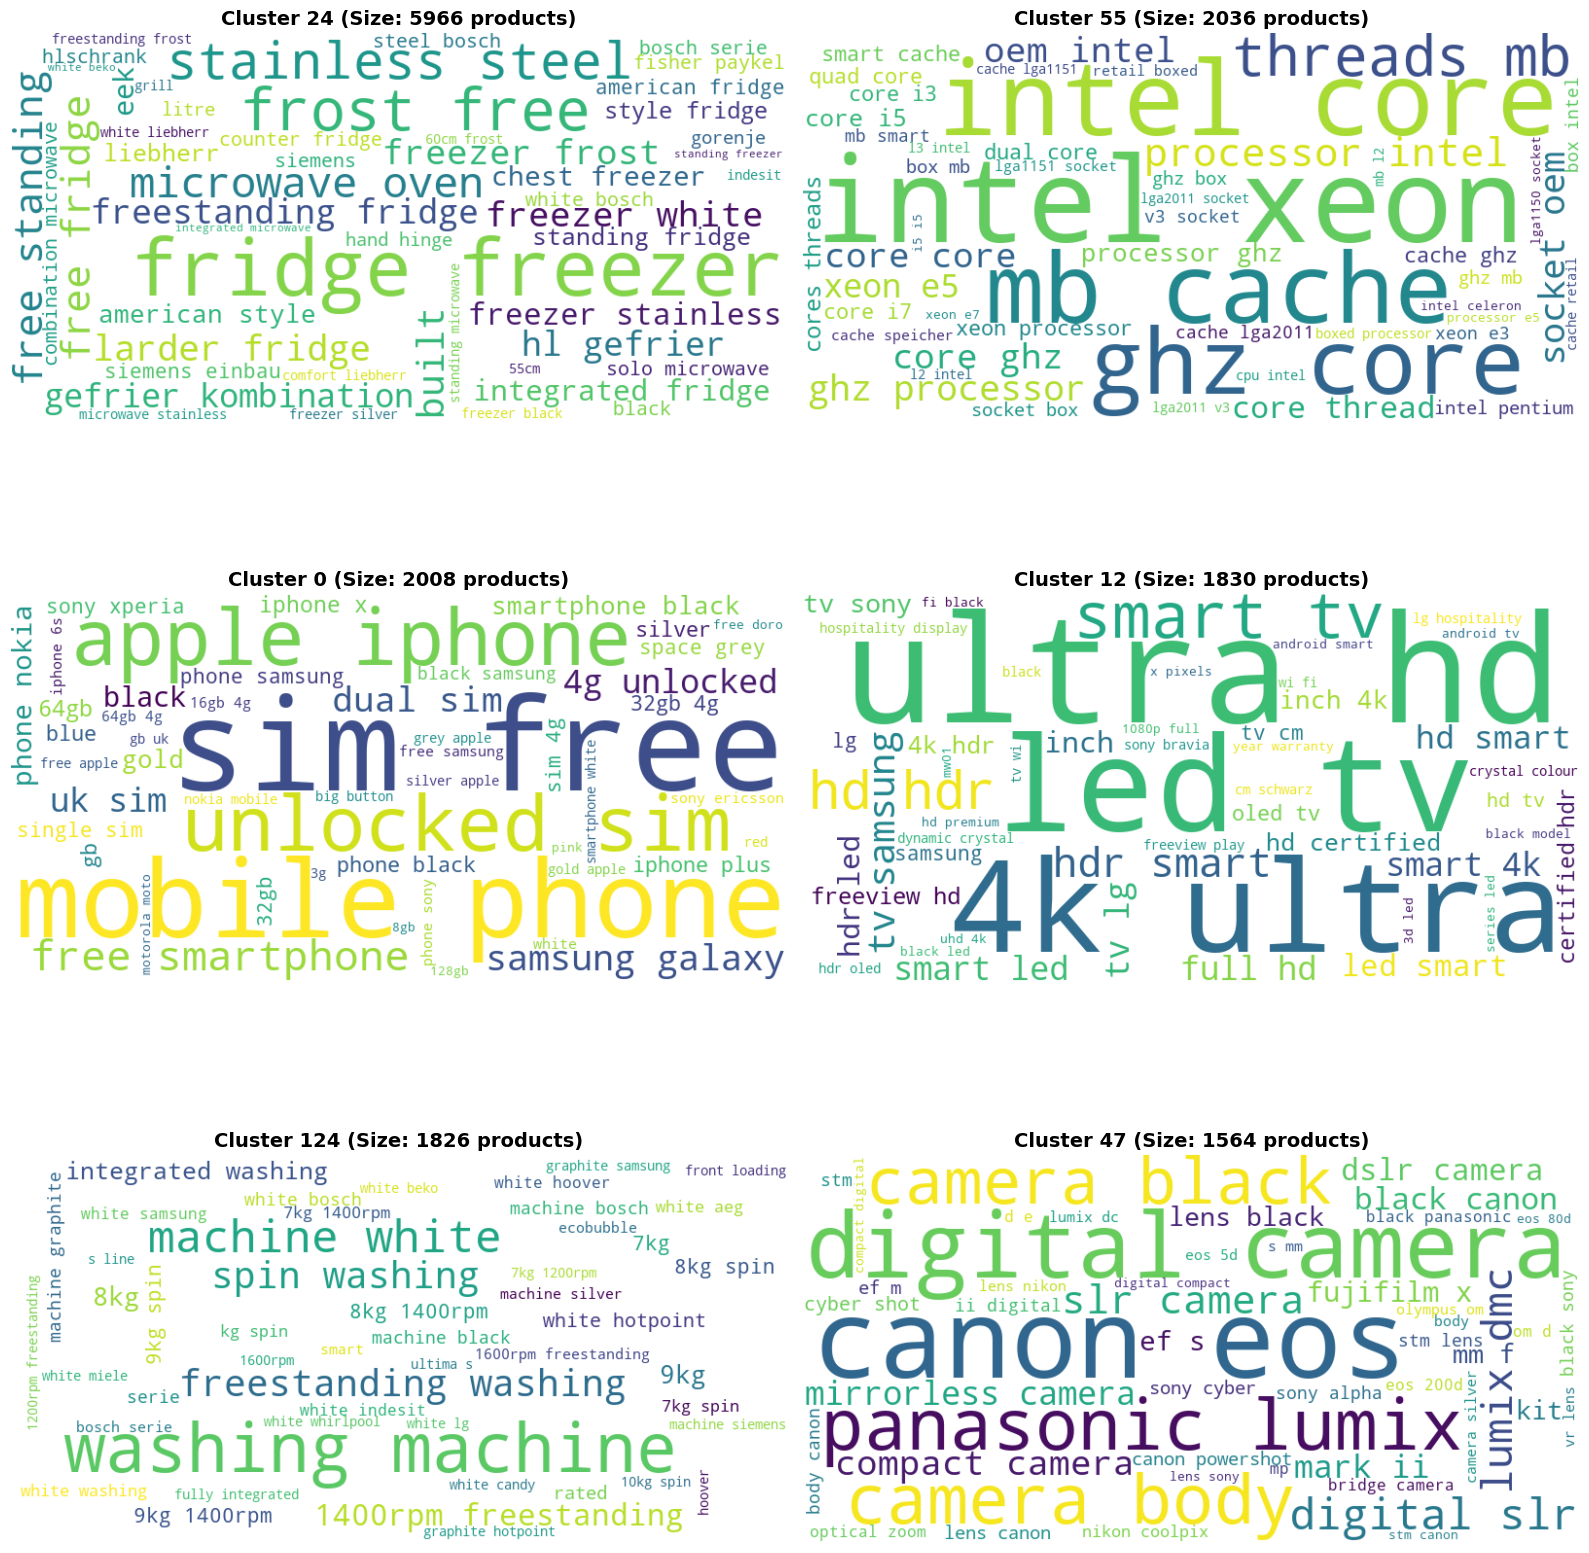


✅ Word clouds generated! Look for:
   • Dominant product brands/models
   • Common attributes (color, size, capacity)
   • Product categories


In [24]:
if len(results_valid) > 0:
    # Optional: Install wordcloud if not already installed
    # !pip install wordcloud

    try:
        from wordcloud import WordCloud
        
        # Function to generate word cloud for a cluster
        def generate_wordcloud_for_cluster(cluster_id, ax=None):
            """Generate word cloud from product titles in a cluster"""
            cluster_data = product[product['DBSCAN_Cluster'] == cluster_id]
            
            # Combine all titles
            all_text = ' '.join(cluster_data['Product Title'].str.lower())
            
            # Generate word cloud
            wordcloud = WordCloud(
                width=800, 
                height=400,
                background_color='white',
                colormap='viridis',
                max_words=50,
                relative_scaling=0.5
            ).generate(all_text)
            
            # Plot
            if ax is None:
                plt.figure(figsize=(12, 6))
                ax = plt.gca()
            
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(f'Cluster {cluster_id} (Size: {len(cluster_data)} products)', fontsize=14, fontweight='bold')
            
            return wordcloud
        
        # Generate word clouds for top 6 largest clusters
        top_clusters_for_wordcloud = cluster_sizes_no_noise.head(6).index
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        axes = axes.flatten()
        
        print("🎨 Generating word clouds for top 6 largest clusters...\n")
        
        for idx, cluster_id in enumerate(top_clusters_for_wordcloud):
            print(f"  Generating word cloud for cluster {cluster_id}...")
            generate_wordcloud_for_cluster(cluster_id, ax=axes[idx])
        
        plt.tight_layout()
        plt.show()
        
        print("\n✅ Word clouds generated! Look for:")
        print("   • Dominant product brands/models")
        print("   • Common attributes (color, size, capacity)")
        print("   • Product categories")
        
    except ImportError:
        print("⚠️  WordCloud library not installed.")
        print("To install: !pip install wordcloud")
        print("Skipping word cloud visualization...")

### 10.7 Manual Coherence Scoring (Interactive)

For a truly qualitative assessment, manually score a random sample of clusters.

In [23]:
if len(results_valid) > 0 and len(purity_df) > 0:
    # Sample 10 random clusters of varying sizes for manual inspection
    print("=" * 100)
    print("MANUAL COHERENCE EVALUATION - SAMPLE 10 RANDOM CLUSTERS")
    print("=" * 100)
    print("\nFor each cluster, evaluate:")
    print("  1. Do products look similar/related based on titles?")
    print("  2. Would you group these products together?")
    print("  3. Rate coherence: High (most products similar) / Medium / Low (mixed/unrelated)")
    print("\n" + "=" * 100 + "\n")

    # Sample clusters from different sizes
    sample_clusters = []

    # 3 from large (top 25%)
    large_threshold = purity_df['Size'].quantile(0.75)
    large_clusters = purity_df[purity_df['Size'] >= large_threshold]['DBSCAN_Cluster'].values
    if len(large_clusters) >= 3:
        sample_clusters.extend(np.random.choice(large_clusters, 3, replace=False))

    # 4 from medium (25-75%)
    medium_min = purity_df['Size'].quantile(0.25)
    medium_max = purity_df['Size'].quantile(0.75)
    medium_clusters = purity_df[
        (purity_df['Size'] >= medium_min) & (purity_df['Size'] < medium_max)
    ]['DBSCAN_Cluster'].values
    if len(medium_clusters) >= 4:
        sample_clusters.extend(np.random.choice(medium_clusters, 4, replace=False))

    # 3 from small (bottom 25%)
    small_threshold = purity_df['Size'].quantile(0.25)
    small_clusters = purity_df[purity_df['Size'] < small_threshold]['DBSCAN_Cluster'].values
    if len(small_clusters) >= 3:
        sample_clusters.extend(np.random.choice(small_clusters, 3, replace=False))

    # Display each cluster for manual evaluation
    for idx, cluster_id in enumerate(sample_clusters, 1):
        cluster_data = product[product['DBSCAN_Cluster'] == cluster_id]
        cluster_info = purity_df[purity_df['DBSCAN_Cluster'] == cluster_id].iloc[0]
        
        print(f"\n{'=' * 100}")
        print(f"CLUSTER {idx}/10 | DBSCAN Cluster ID: {cluster_id}")
        print(f"Size: {len(cluster_data)} products | Purity: {cluster_info['Purity']:.3f} | "
              f"GT Clusters Mixed: {cluster_info['Num_GT_Merged']}")
        print(f"{'=' * 100}\n")
        
        # Show all products (or sample if too large)
        display_sample = cluster_data.sample(n=min(15, len(cluster_data)), random_state=42)
        
        for i, (_, row) in enumerate(display_sample.iterrows(), 1):
            print(f"  {i:2d}. {row['Product Title']}")
        
        if len(cluster_data) > 15:
            print(f"  ... and {len(cluster_data) - 15} more products")
        
        print(f"\n  💭 YOUR ASSESSMENT: [ ] High coherence  [ ] Medium coherence  [ ] Low coherence")
        print(f"  📝 NOTES: _________________________________________________________________")
        print()

    print("\n" + "=" * 100)
    print("✅ Manual evaluation complete!")
    print("\nSummary questions:")
    print("  • What % of clusters have HIGH coherence (products clearly related)?")
    print("  • What % have MEDIUM coherence (somewhat related, or mixed)?")
    print("  • What % have LOW coherence (seems random/poorly clustered)?")
    print("  • Overall, does DBSCAN produce meaningful groupings for YOUR use case?")
    print("=" * 100)

MANUAL COHERENCE EVALUATION - SAMPLE 10 RANDOM CLUSTERS

For each cluster, evaluate:
  1. Do products look similar/related based on titles?
  2. Would you group these products together?
  3. Rate coherence: High (most products similar) / Medium / Low (mixed/unrelated)



CLUSTER 1/10 | DBSCAN Cluster ID: 43
Size: 133 products | Purity: 0.045 | GT Clusters Mixed: 82.0

   1. grade a lg 32lj590u 32 inch hd ready smart led tv with webos
   2. lg electronics 28mt49df hd ready 720p 27.5 inch led tv 2017 model
   3. panasonic tx32e302b 32 hd ready smart led television
   4. linsar 24 bluetooth led tv freeview hd dvd soundbar
   5. reflexion ldd1616 led tv 39.6 cm 15.6 eec a dvb t2 dvb c dvb s hd ready dvd player ci black
   6. samsung t24e310ex 24 hd ready led tv monitor freeview hd media player
   7. samsung ue32j4100 hd ready 32 inch television 2015 model
   8. sharp 24 smart led tv dvd combi hd ready 720p freeview hd usb media pvr
   9. cello c32229t2 32 inch curved hd ready led tv
  10. 

---

## 📊 Qualitative Evaluation Summary

### How to Interpret Results:

**✅ Good Signs (DBSCAN is working):**
- High purity scores (≥0.7) for most clusters
- Cluster samples show clear product similarity
- Noise points are genuinely unique/outlier products
- Word clouds show coherent themes per cluster
- Manual inspection reveals meaningful groupings

**⚠️ Warning Signs (May need adjustments):**
- Low average purity (<0.5)
- Clusters mix unrelated products
- Too many noise points (>40%)
- Manual inspection shows random groupings

**🔧 What to Try Next:**
1. **Adjust parameters** - Try different eps/min_samples from grid search
2. **Better embeddings** - Use BERT/Sentence-BERT instead of TF-IDF
3. **Try HDBSCAN** - Adapts to varying density automatically
4. **Feature engineering** - Add brand, category, price info
5. **Accept the results** - If clusters make business sense, low ARI is OK!

### Key Question:
**Does DBSCAN produce clusters that are useful for YOUR downstream task?**
- Product recommendation? Duplicate detection? Categorization?
- If yes → Success! (regardless of ARI score)
- If no → Time to try alternatives